# Configuration

NOTES: The warnings after the import are referred to the fact that Tensorflow 2.x versions are built to directly look for a GPU in the system. The warning can be forgot if you are not going to use the GPU. 

In [1]:
!source myenv/bin/activate

In [12]:
LENGTH_CHOSEN = 126520

In [2]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
import pickle
import scipy
import ipywidgets
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, AveragePooling1D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# from livelossplot import PlotLossesKeras
tf.config.list_physical_devices('GPU')

2021-09-01 11:35:14.540658: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-01 11:35:14.540677: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-01 11:35:15.416333: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-01 11:35:15.416923: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-01 11:35:15.490788: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-01 11:35:15.490807: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (helemanc-Latitude-5410): /pr

[]

# Load Dataframes

In [3]:
preprocess_path = "/home/helemanc/Desktop/Binary_Model/pre-processed"

RAV_df = pd.read_csv(os.path.join(preprocess_path,"RAV_df.csv"))

In [4]:
RAV_train = []
RAV_val = []
RAV_test = []

In [5]:
for index, row in RAV_df.iterrows():
    if row['actors'] in range(1,21): 
        RAV_train.append(row) 
    elif row['actors'] in range(21,23): 
        RAV_val.append(row)
    elif row['actors'] in range(23,25): 
        RAV_test.append(row)
len(RAV_train), len(RAV_val), len(RAV_test)

(1200, 120, 120)

In [6]:
RAV_train = pd.DataFrame(RAV_train)
RAV_val = pd.DataFrame(RAV_val)
RAV_test = pd.DataFrame(RAV_test)

In [7]:
RAV_train = RAV_train.drop(['actors'], 1)
RAV_val = RAV_val.drop(['actors'], 1)
RAV_test = RAV_test.drop(['actors'], 1)

In [8]:
df_train = RAV_train.reset_index(drop=True) 
df_val = RAV_val.reset_index(drop=True) 
df_test = RAV_test.reset_index(drop=True) 

# Feature extraction

In [10]:
df_train['emotion_label'].unique()

array(['disgust', 'surprise', 'sadness', 'angry', 'fear', 'happy', 'calm',
       'neutral'], dtype=object)

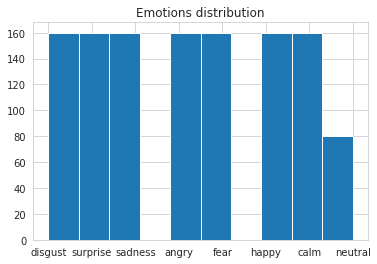

In [11]:
plt.title('Emotions distribution')
plt.hist(df_train['emotion_label'])
# plt.hist(y)
plt.show()

In [ ]:
plt.title('Emotions distribution')
plt.hist(df_val['emotion_label'])
# plt.hist(y)
plt.show()

In [ ]:
plt.title('Emotions distribution')
plt.hist(df_test['emotion_label'])
# plt.hist(y)
plt.show()

In [ ]:
df_train.shape

## Utils

In [24]:
def load_files(df):
    X = []
    for i in tqdm(df['path']): 
        s = librosa.load(i, res_type='kaiser_fast', sr=16000)
        if librosa.get_duration(s[0]) > 3.5: 
            s = librosa.load(i, res_type='kaiser_fast', sr=16000, duration = 3.5)
            X.append(s)
    return X

def extract_samples(X): 
    samples = []
    for ind,i in enumerate(X):
        samples.append(i[0])
    return samples 

def extract_labels(df): 
    labels = df['emotion_label'].copy()
    return labels 

def compute_lengths(samples): 
    lengths = [len(x) for x in samples]
    return lengths 

def check_outliers(lengths):
    # outliers
    lengths = np.array(lengths)
    print((lengths > 300000).sum())
    new_lengths = lengths[lengths < 300000]
    return new_lengths 

def compute_mean_length(lengths): 
    return lengths.mean()

def cut_and_pad(samples, labels, length_chosen = LENGTH_CHOSEN): 
    X_new = []
    y_new = []
    count = 0 
    for ind,i in enumerate(samples):
        if i.shape[0] < 300000:
            if i.shape[0] > length_chosen:
                new = i[:length_chosen]
                X_new.append(new)
            elif i.shape[0] < length_chosen:
                new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
                X_new.append(new)
            else:
                X_new.append(i)
            y_new.append(labels[count])
        count+=1
    
    return X_new, y_new

# Data Augmentation 
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Data Augmentation 
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
    
def compute_mfccs(samples): 
    mfccs = []
    for i in tqdm(samples):
        mfcc = librosa.feature.mfcc(y=i, sr=16000, n_mfcc=13)
        mfcc = mfcc.T
        mfcc = np.array(mfcc)
        mfccs.append(mfcc[:, 1:])
    mfccs = np.array(mfccs)
    return mfccs

def compute_mfccs_augmentation(samples, labels): 
    mfccs = []
    counter = 0 
    for i in tqdm(samples):

       # Weiner Filtering on original noise 
        samples_weiner = scipy.signal.wiener(i)
        is_fin = np.isfinite(samples_weiner).all()


        # Data Augmentation - Noise 
        noise_audio = noise(samples_weiner)

        # Data Augmentation - Pitch 
        pitch_audio = pitch(samples_weiner, sampling_rate=16000)


        # Data Augmentation -  pitch + noise 
        pn = pitch(noise_audio, sampling_rate = 16000)


        if is_fin: 
          # MFCC

          mfcc = librosa.feature.mfcc(y=i, sr=16000, n_mfcc=13)
          mfcc = mfcc.T
          mfccs.append(mfcc[:, 1:])

          mfcc_augmented = librosa.feature.mfcc(y=samples_weiner, sr=16000, n_mfcc=13)
          mfcc_augmented = mfcc_augmented.T
          mfccs.append(mfcc_augmented[:, 1:])

          mfcc_augmented_pitch = librosa.feature.mfcc(y=noise_audio, sr=16000, n_mfcc=13)
          mfcc_augmented_pitch = mfcc_augmented_pitch.T
          mfccs.append(mfcc_augmented_pitch[:, 1:])

          mfcc_augmented_p = librosa.feature.mfcc(y=pitch_audio, sr=16000, n_mfcc=13)
          mfcc_augmented_p = mfcc_augmented_p.T
          mfccs.append(mfcc_augmented_p[:, 1:]) 

          mfcc_augmented_pn = librosa.feature.mfcc(y=pn, sr=16000, n_mfcc=13)
          mfcc_augmented_pn = mfcc_augmented_pn.T
          mfccs.append(mfcc_augmented_pn[:, 1:]) 
    
    mfccs = np.array(mfccs)
    
    # Copy labels 
    y_prov = []
    y = labels 
    for i in range(len(y)): 
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
    y = np.asarray(y_prov)

    return mfccs, y 





## Train

### Load samples and labels 

In [25]:
load_train = load_files(df_train)

100%|█████████████████████████████████████| 1200/1200 [00:00<00:00, 2444.76it/s]


In [26]:
len(load_train)

6

In [27]:
samples_train = extract_samples(load_train)

In [28]:
labels_train = extract_labels(df_train)

### Decide length

In [29]:
lengths = compute_lengths(samples_train) 

In [30]:
lengths

[56000, 56000, 56000, 56000, 56000, 56000]

In [ ]:
new_lengths = check_outliers(lengths) 

In [ ]:
mean_length = compute_mean_length(new_lengths)

In [ ]:
mean_length

### Cut and Pad

In [16]:
samples_train, labels_train = cut_and_pad(samples_train, labels_train)

In [17]:
samples_train = np.array(samples_train)
labels_train = np.array(labels_train)
print(samples_train.shape, labels_train.shape)

(1200,) (1200,)


### Feature Extraction - Without Data Augmentation 

In [18]:
mfccs_train = compute_mfccs(samples_train)

100%|███████████████████████████████████████| 1200/1200 [00:19<00:00, 63.15it/s]


In [19]:
mfccs_train.shape

(1200, 248, 12)

### Save features and labels

In [ ]:
'''
preprocess_path = "/home/helemanc/Desktop/Binary_Model/pre-processed"
mfccs_train_path = os.path.join(preprocess_path,"mfccs_train.pkl")
labels_train_path = os.path.join(preprocess_path,"labels_train.pkl")

with open(mfccs_train_path, 'wb') as f:
        pickle.dump(mfccs_train , f)
        
with open(labels_train_path, 'wb') as f:
        pickle.dump(labels_train , f)
'''

### Feature Extraction - With Data Augmentation

In [ ]:
mfccs_train_aug, labels_train_aug = compute_mfccs_augmentation(samples_train, labels_train)

In [ ]:
mfccs_train_aug.shape, labels_train_aug.shape

### Save features and labels

In [ ]:
preprocess_path = "/home/helemanc/Desktop/Binary_Model/pre-processed"
mfccs_aug_train_path = os.path.join(preprocess_path,"mfccs_train_aug.pkl")
labels_aug_train_path = os.path.join(preprocess_path,"labels_train_aug.pkl")

with open(mfccs_aug_train_path, 'wb') as f:
        pickle.dump(mfccs_train_aug , f)
        
with open(labels_aug_train_path, 'wb') as f:
        pickle.dump(labels_train_aug , f)

## Val

### Load samples and labels

In [20]:
load_val = load_files(df_val)

100%|███████████████████████████████████████| 120/120 [00:00<00:00, 1444.08it/s]


In [21]:
samples_val = extract_samples(load_val)

In [22]:
labels_val = extract_labels(df_val)

### Cut and Pad 

In [23]:
samples_val, labels_val = cut_and_pad(samples_val, labels_val)

In [24]:
samples_val = np.array(samples_val)
labels_val = np.array(labels_val)
print(samples_val.shape, labels_val.shape)

(120,) (120,)


### Feature Extraction

In [25]:
mfccs_val = compute_mfccs(samples_val)

100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 63.51it/s]


In [26]:
mfccs_val.shape

(120, 248, 12)

### Save features and labels

In [ ]:
preprocess_path = "/home/helemanc/Desktop/Binary_Model/pre-processed"
mfccs_val_path = os.path.join(preprocess_path,"mfccs_val.pkl")
labels_val_path = os.path.join(preprocess_path,"labels_val.pkl")

with open(mfccs_val_path, 'wb') as f:
        pickle.dump(mfccs_val , f)
        
with open(labels_val_path, 'wb') as f:
        pickle.dump(labels_val , f)

## Test

### Load samples and labels

In [27]:
load_test = load_files(df_test)

100%|███████████████████████████████████████| 120/120 [00:00<00:00, 1936.55it/s]


In [28]:
samples_test = extract_samples(load_test)

In [29]:
labels_test = extract_labels(df_test)

### Cut and Pad 

In [30]:
samples_test, labels_test = cut_and_pad(samples_test, labels_test)

In [31]:
samples_test = np.array(samples_test)
labels_test = np.array(labels_test)
print(samples_test.shape, labels_test.shape)

(120,) (120,)


### Feature Extraction

In [32]:
mfccs_test = compute_mfccs(samples_test)

100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 63.69it/s]


In [33]:
mfccs_test.shape

(120, 248, 12)

### Save features and labels

In [ ]:
preprocess_path = "/home/helemanc/Desktop/Binary_Model/pre-processed"
mfccs_test_path = os.path.join(preprocess_path,"mfccs_test.pkl")
labels_test_path = os.path.join(preprocess_path,"labels_test.pkl")

with open(mfccs_test_path, 'wb') as f:
        pickle.dump(mfccs_test , f)
        
with open(labels_test_path, 'wb') as f:
        pickle.dump(labels_test , f)

# Encode Labels - Binary 

In [34]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}

In [35]:
y_train = pd.Series(labels_train).replace(emotion_enc)
y_val = pd.Series(labels_val).map(emotion_enc)
y_test = pd.Series(labels_test).map(emotion_enc)
#y_train_aug = pd.Series(labels_train_aug).map(emotion_enc)

# Train, Val, Test (X) 

In [36]:
X_train = mfccs_train
X_val = mfccs_val
X_test = mfccs_test 

# Standard Scaling 

## Without Augmentation

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

## With Augmentation

In [ ]:
X_train_aug = mfccs_train_aug
y_train_aug = labels_train_aug
X_val = mfccs_val
X_test = mfccs_test 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_aug = scaler.fit_transform(X_train_aug.reshape(-1, X_train.shape[-1])).reshape(X_train_aug.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

# Model 

In [ ]:
model = Sequential()

model.add(layers.Conv1D(256, 5,padding='same',
                 input_shape=(248,12), kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(4)))
model.add(layers.Dropout(0.6))

model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(4)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(64,  kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.summary()

# Training

## Without Augmentation

### Load Data

In [ ]:
'''
X_train = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_train.pkl", 'rb'))
X_val = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_val.pkl", 'rb'))
X_test = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_test.pkl", 'rb'))
y_train = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_train.pkl", 'rb'))
y_val = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_val.pkl", 'rb'))
y_test =  pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_test.pkl", 'rb'))
'''

In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [ ]:
weight_path = "/home/helemanc/Desktop/Binary_Model/weights/binary_model_l1l2.hdf5"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)
# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}


In [ ]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics='accuracy')

### Train

In [ ]:
history = model.fit(X_train, y_train, batch_size=4, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, model_checkpoint], class_weight = class_weights)

### Plot Training Graphs

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Save Model

In [ ]:
model.save("/home/helemanc/Desktop/Binary_Model/models/binary_model_ravdess_13_83")

### Evaluate Model

In [ ]:
model_loaded = tf.keras.models.load_model("/home/helemanc/Desktop/Binary_Model/models/binary_model")

In [ ]:
model.evaluate(X_test, y_test, batch_size=8)

In [ ]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

## With Augmentation

### Load Data

In [ ]:
'''
X_train_aug = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model_augmented/X_train_aug.pkl", 'rb'))
X_val = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model_augmented/X_val.pkl", 'rb'))
X_test = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model_augmented/X_test.pkl", 'rb'))
y_train_aug = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model_augmented/y_train_aug.pkl", 'rb'))
y_val = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model_augmented/y_val.pkl", 'rb'))
y_test =  pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model_augmented/y_test.pkl", 'rb'))
'''

In [ ]:
X_train_aug = mfccs_train_aug
y_train_aug = labels_train_aug 

In [ ]:
from sklearn.utils import shuffle
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)

In [ ]:
(unique, counts) = np.unique(y_train_aug, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

In [ ]:
weight_path = "/home/helemanc/Desktop/Binary_Model/weights/binary_model_augmented.hdf5"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)
# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_aug), y_train_aug)
class_weights = {l:c for l,c in zip(np.unique(y_train_aug), class_weights)}


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

### Train

In [ ]:
history = model.fit(X_train_aug, y_train_aug, batch_size=16, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, model_checkpoint], class_weight = class_weights)


### Plot Training Graphs

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Save Model

In [ ]:
model.save("/home/helemanc/Desktop/Binary_Model/models/binary_model_aug")

### Evaluate Model

In [ ]:
model_loaded = tf.keras.models.load_model("/home/helemanc/Desktop/Binary_Model/models/binary_model_aug")

In [ ]:
model_loaded.evaluate(X_test, y_test, batch_size=16)

In [ ]:
from sklearn.metrics import classification_report
predictions = model_loaded.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

# Hyprparameter optimization 

In [38]:
def create_model(optimizer='adam', init_mode='glorot_uniform'):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(248,12), kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(64,  kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    return model

In [39]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Initializer

In [40]:
weight_path = "/home/helemanc/Desktop/Binary_Model/weights/binary_model_l1l2.hdf5"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)
# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}


In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
#import tensorflow as tf 
#from tf.keras.wrappers.scikit_learn import KerasClassifier

seed = 7
np.random.seed(seed)
batch_size = 4
epochs = 30

model_CV = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 
             'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

param_grid = dict(init_mode=init_mode)
grid = RandomizedSearchCV(estimator=model_CV, param_distributions=param_grid, n_jobs=-1, cv=KFold(3), verbose = 10 )
grid_result = grid.fit(X_train, y_train, callbacks=[reduce_lr, early_stop], class_weight = class_weights)

In [44]:
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.8583333293596903 using {'init_mode': 'zero'}
 mean=0.8492, std=0.02786 using {'init_mode': 'uniform'}
 mean=0.8417, std=0.02183 using {'init_mode': 'lecun_uniform'}
 mean=0.8467, std=0.01586 using {'init_mode': 'normal'}
 mean=0.8583, std=0.01477 using {'init_mode': 'zero'}
 mean=0.8483, std=0.0123 using {'init_mode': 'glorot_normal'}
 mean=0.8358, std=0.03859 using {'init_mode': 'glorot_uniform'}
 mean=0.8567, std=0.01359 using {'init_mode': 'he_normal'}
 mean=0.8467, std=0.01359 using {'init_mode': 'he_uniform'}


## Initializer, Batch Size, Learning Rate 

In [75]:
def create_model( init_mode='glorot_uniform', lr = 0.001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(248,12), kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [77]:
weight_path = "/home/helemanc/Desktop/Binary_Model/weights/binary_model_l1l2.hdf5"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)
# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}


In [78]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
#import tensorflow as tf 
#from tf.keras.wrappers.scikit_learn import KerasClassifier

seed = 7
np.random.seed(seed)
batch_size = 4
epochs = 50

model_CV = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'glorot_uniform', 'glorot_normal']
batches = [4,8,16]
lr = [0.001, 0.0001, 0.00005]

param_grid = dict(init_mode=init_mode, lr = lr, batch_size = batches)
grid = RandomizedSearchCV(estimator=model_CV, param_distributions=param_grid, n_jobs=-1, cv=KFold(3))
grid_result = grid.fit(X_train, y_train, callbacks=[reduce_lr, early_stop], class_weight = class_weights)

2021-08-30 14:59:57.426678: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-30 14:59:57.426899: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-30 14:59:57.521660: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-30 14:59:57.521891: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-30 14:59:57.557426: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

KeyboardInterrupt: 

In [79]:
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.875 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=0.7508, std=0.002357 using {'lr': 5e-05, 'init_mode': 'glorot_uniform', 'batch_size': 16}
 mean=0.81, std=0.03048 using {'lr': 5e-05, 'init_mode': 'uniform', 'batch_size': 4}
 mean=0.8625, std=0.01947 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 16}
 mean=0.8425, std=0.01021 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size': 4}
 mean=0.8692, std=0.01586 using {'lr': 0.001, 'init_mode': 'glorot_uniform', 'batch_size': 8}
 mean=0.8308, std=0.01961 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.875, std=0.005401 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=0.8467, std=0.01532 using {'lr': 0.001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
 mean=0.8158, std=0.01027 using {'lr': 0.0001, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.7808, std=0.006236 using {'lr': 5e-05, 'init_mode': 'lecun_uniform', 'batch_size':

## Train with best parameters

In [80]:
# Best Accuracy for 0.875 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 4}
def create_model( init_mode='glorot_normal', lr = 0.001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(248,12), kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [81]:
seed = 7
np.random.seed(seed)

In [82]:
model = create_model()

In [83]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [84]:
import datetime, os

In [85]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [86]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2021-08-30 15:00:38.329954: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-08-30 15:00:38.329996: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-08-30 15:00:38.330068: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [87]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1, restore_best_weights = True )

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [88]:
history = model.fit(X_train, y_train, batch_size=4, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, tensorboard_callback], class_weight = class_weights)

Epoch 1/500
 36/300 [==>...........................] - ETA: 1s - loss: 1.6310 - accuracy: 0.5188

2021-08-30 15:00:39.614299: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-08-30 15:00:39.614322: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-08-30 15:00:39.638071: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-08-30 15:00:39.638814: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-08-30 15:00:39.640369: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210830-150037/train/plugins/profile/2021_08_30_15_00_39
2021-08-30 15:00:39.641206: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210830-150037/train/plugins/profile/2021_08_30_15_00_39/helemanc-Latitude-5410.trace.json.gz
2021-08-30 15:00:39.642316: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210830-150037/train/plugins/p

300/300 [==============================] - 2s 6ms/step - loss: 0.9858 - accuracy: 0.5598 - val_loss: 0.5874 - val_accuracy: 0.7000
Epoch 2/500
300/300 [==============================] - 1s 5ms/step - loss: 0.6549 - accuracy: 0.6359 - val_loss: 0.5850 - val_accuracy: 0.7417
Epoch 3/500
300/300 [==============================] - 1s 5ms/step - loss: 0.6241 - accuracy: 0.6656 - val_loss: 0.5521 - val_accuracy: 0.7167
Epoch 4/500
300/300 [==============================] - 1s 5ms/step - loss: 0.5639 - accuracy: 0.7090 - val_loss: 0.4857 - val_accuracy: 0.8000
Epoch 5/500
300/300 [==============================] - 2s 5ms/step - loss: 0.5592 - accuracy: 0.7289 - val_loss: 0.5110 - val_accuracy: 0.8083
Epoch 6/500
300/300 [==============================] - 1s 5ms/step - loss: 0.5287 - accuracy: 0.7204 - val_loss: 0.4807 - val_accuracy: 0.8083
Epoch 7/500
300/300 [==============================] - 2s 5ms/step - loss: 0.5368 - accuracy: 0.7081 - val_loss: 0.4465 - val_accuracy: 0.7667
Epoch 8/500

In [89]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 31441), started 3:45:23 ago. (Use '!kill 31441' to kill it.)

In [90]:
model.evaluate(X_test, y_test, batch_size=4)

30/30 [==============================] - 0s 1ms/step - loss: 0.3353 - accuracy: 0.8667


[0.3352874219417572, 0.8666666746139526]

In [91]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        56
           1       0.90      0.84      0.87        64

    accuracy                           0.87       120
   macro avg       0.87      0.87      0.87       120
weighted avg       0.87      0.87      0.87       120



## Save best model 

In [92]:
model.save("/home/helemanc/Desktop/Binary_Model/models/binary_model_ravdess_13_after_optimization")

2021-08-30 15:57:30.426908: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/helemanc/Desktop/Binary_Model/models/binary_model_ravdess_13_after_optimization/assets
